In [37]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [257]:
os.getcwd()

'/zhome/27/c/138037/share/src'

In [324]:
train_path = '/zhome/27/c/138037/share/data/train/'
test_path = '/zhome/27/c/138037/share/data/test/'
classes = {'Barley':0, 'Broken':1, 'Oat':2, 'Rye':3, 'Wheat':4}
barley_dim = np.load(os.getcwd() + '/barley_dim.npy')
broken_dim = np.load(os.getcwd() + '/broken_dim.npy')
oat_dim = np.load(os.getcwd() + '/oat_dim.npy')
rye_dim = np.load(os.getcwd() + '/rye_dim.npy')
wheat_dim = np.load(os.getcwd() + '/wheat_dim.npy')
dim_means = [np.mean(barley_dim[1:], axis=0), np.mean(broken_dim[1:], axis=0), np.mean(oat_dim[1:], axis=0), np.mean(rye_dim[1:], axis=0), np.mean(wheat_dim[1:], axis=0)]


In [328]:
[print(i) for i in dim_means]
height = 117
width = 40
distance = [np.linalg.norm(np.array([height,width]) - i) for i in dim_means]

[144.05726138  61.16304308]
[78.57508343 56.18020022]
[162.74412919  49.79568857]
[117.61908878  41.89517224]
[110.98363471  58.07111829]


In [329]:
distance

[34.350688284385896,
 41.6926023768706,
 46.78120210445162,
 1.9937273498494459,
 19.046311131544844]

In [383]:
def imgscaler(image, height=256, width=128):
    #scale the image up to batch_size and pad remaining
    
    hscaler = height/image.shape[0]
    wscaler = width/image.shape[1]
    scaler = np.zeros(2)
    if hscaler > wscaler:
        image = cv2.resize(image,dsize=(0,0),fx=wscaler,fy=wscaler,interpolation=cv2.INTER_LINEAR)
        pad =  height - image.shape[0]
        top = int(np.floor(pad * 0.5))
        bottom = int(pad-top)
        image = np.pad(image, ((top,bottom),(0,0),(0,0)), 'constant', constant_values=(0,0))


    elif hscaler < wscaler:
        image = cv2.resize(image,dsize=(0,0),fx=hscaler,fy=hscaler,interpolation=cv2.INTER_LINEAR)
        pad = width - image.shape[1]
        left = int(np.floor(pad * 0.5))
        right = int(pad-left)
        image = np.pad(image, ((0,0),(left,right),(0,0)), 'constant', constant_values=(0,0))

    else:
        #Perfect fit no padding needed
        image = cv2.resize(image,dsize=(0,0),fx=wscaler,fy=hscaler,interpolation=cv2.INTER_LINEAR)
    return image
    
def masker(image):
    #create a simple mask, and make everything else 0
    mask = np.zeros((image.shape[0],image.shape[1]))
    temp_blue = image[:,:,1].copy()
    temp_blue[temp_blue==0] = 1
    mask[image[:,:,4]/temp_blue >= 1] = 1
    mask[image[:,:,4] >= 40] = 1
    mask[:5,:5] = 0
    image[mask==0] = 0

    #assesing 'straw' outlier in barley class
    if image.shape[0] >= 400:
        upper_mask = mask[:200]
        lower_mask = mask[-200:]

        #find half with the kernel
        if len(np.flatnonzero(upper_mask)) > len(np.flatnonzero(lower_mask)):
            image = image[:200]
            mask = mask[:200]
        elif len(np.flatnonzero(upper_mask)) < len(np.flatnonzero(lower_mask)):
            image = image[-200:]
            mask = mask[-200:]
    return image, mask

def find_diag(image, mask):
    '''
    return length of diagonal i.e 45degree cut from corner to opposite corner
    and coordinates to where the cross-section begins and ends
    '''
    #Find length of corner to corner vector
    len_diag = np.sqrt(mask.shape[0]**2 + mask.shape[1]**2)
    eye = np.eye(int(len_diag))
    diag = cv2.resize(eye, dsize=(image.shape[1], image.shape[0]), interpolation=cv2.INTER_LANCZOS4)
    l = len(np.ma.masked_greater(diag, 0))
    mean = np.mean(np.ma.where(diag)) / l

    diag[np.ma.masked_greater_equal(diag, mean).mask] = 1
    diag[np.ma.masked_less(diag, mean).mask] = 0

    diag[mask == 0] = 0
    #mask[temp == 1] = 0
    return len(temp[temp == 1]), np.min(np.where(temp)[1]), np.max(np.where(mask)[1]), np.min(np.where(mask)[0]), np.max(np.where(mask)[0])

def make_dataset(path, dim_means, classes):
    '''
    init feature extraction. Returns height, width, depth, mean_depth, average-channel-intensity, mask-size, class
    '''
    #path = path
    #dim_means = dim_means
    data = np.zeros(13).reshape(1,13)
    for category in list(classes.keys()):
        file_paths = next(os.walk(path  + category))[2]    
        for file in file_paths:
            image, mask = masker(np.load(os.path.join(path + category + '/' + file)))
            intensity = np.mean(image[mask == 1], axis=0)[:7] / np.array([1, 0.94901961, 0.96078432, 0.99215686, 0.99607843, 1, 0.59215689])
            min_x = np.min(np.where(mask)[1])
            max_x = np.max(np.where(mask)[1])
            min_y = np.min(np.where(mask)[0])
            max_y = np.max(np.where(mask)[0])
            height = max_y-min_y
            width = max_x-min_x
            len_diag1, x_begin_diag1, x_end_diag1, y_begin_diag1, y_end_diag1 = find_diag(image, mask)
            len_diag2, x_begin_diag2, x_end_diag2, y_begin_diag2, y_end_diag2 = find_diag(np.fliplr(image), np.fliplr(mask))
            distance = [np.linalg.norm(np.array([height,width]) - i) for i in dim_means]
            size = len(np.where(mask)[0]) / np.mean(len_diag1+len_diag2)#(image.shape[0]*image.shape[1])
            depth = np.max(image[:,:,6])
            

            data = np.append(data, [[height,width,depth,size,intensity[0],intensity[1],intensity[2],intensity[3],intensity[4],intensity[5],intensity[6],np.argmin(distance),classes[category]]], axis=0)
    return data


In [384]:
test = make_dataset(test_path, dim_means, classes)
train = make_dataset(train_path, dim_means, classes)
np.save('test_featuredata.npy', test)
np.save('train_featuredata.npy', train)

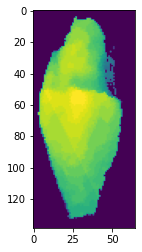

In [380]:
plt.imshow(image[:,:,6])
plt.show()


In [375]:
print(np.mean(image[mask == 1], axis=0)[:7])

print(np.mean(image[mask == 1], axis=0)[:7] / np.array([1, 0.94901961, 0.96078432, 0.99215686, 0.99607843, 1, 0.59215689]))


[ 24.26163283  60.17724196  78.07254653  98.9323181  114.7605753
 192.46594755  29.27622673]
[ 24.26163283  63.40990358  81.25918055  99.71439204 115.21238874
 192.46594755  49.43998327]


153


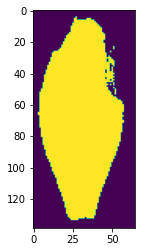

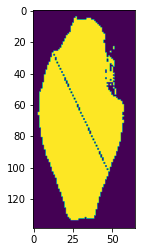

46


In [351]:
#Developmenting
image, mask = masker(np.load(os.path.join(path + category + '/' + file_paths[0])))
temp = np.sqrt(mask.shape[0]**2 + mask.shape[1]**2)
print(int(temp))
plt.imshow(mask)
plt.show()

eye = np.eye(int(temp))
temp = cv2.resize(eye, dsize=(image.shape[1], image.shape[0]), interpolation=cv2.INTER_LANCZOS4)

l = len(np.ma.masked_greater(temp, 0))
mean = np.mean(np.ma.where(temp)) / l

temp[np.ma.masked_greater_equal(temp, mean).mask] = 1
temp[np.ma.masked_less(temp, mean).mask] = 0

temp[mask == 0] = 0
mask[temp == 1] = 0
plt.imshow(mask)
plt.show()
print(len(temp[temp == 1]))

In [51]:
path = os.path.join(cwd, os.listdir(cwd)[10000])
image = np.load(path)

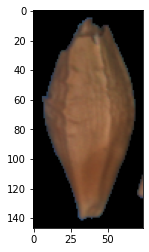

(array([  5,   5,   5, ..., 140, 141, 141]), array([36, 37, 38, ..., 39, 32, 33]))


In [95]:
scaled_image = imgscaler(image, 256,128)
scaled_img, scaled_mask = masker(scaled_image)
img, mask = masker(image)
plt.imshow(img[:,:,[4,2,1]])
plt.show()
print(np.where(mask == 1))

#plt.imshow(scaled_img[:,:,[4,2,1]])
#plt.show()
#print(np.where(scaled_mask == 1))

In [323]:
path = '/zhome/27/c/138037/share/data/train/'
classes = {'Barley':0, 'Broken':1, 'Oat':2, 'Rye':3, 'Wheat':4}

# init feature extraction dataset samples = 66000, height, width, average-channel-intensity, mask-size, class
broken_dim = np.zeros(2).reshape(1,2)
barley_dim = np.zeros(2).reshape(1,2)
oat_dim = np.zeros(2).reshape(1,2)
rye_dim = np.zeros(2).reshape(1,2)
wheat_dim = np.zeros(2).reshape(1,2)

for category in list(classes.keys()):
    #print(category)
    file_paths = next(os.walk(path  + category))[2]
    i = 0
    for file in file_paths:
        #print(file)
        image, mask = masker(np.load(os.path.join(path + category + '/' + file)))
        min_x = np.min(np.where(mask)[1])
        max_x = np.max(np.where(mask)[1])
        min_y = np.min(np.where(mask)[0])
        max_y = np.max(np.where(mask)[0])
        height = max_y-min_y
        width = max_x-min_x
        size = image.shape
        
        if category == 'Broken':
            broken_dim = np.append(broken_dim, [[height,width]], axis=0)
            
        if category == 'Barley':
            barley_dim = np.append(barley_dim, [[height,width]], axis=0)
            
        if category == 'Oat':
            oat_dim = np.append(oat_dim, [[height,width]], axis=0)
            
        if category == 'Rye':
            rye_dim = np.append(rye_dim, [[height,width]], axis=0)
            
        if category == 'Wheat':
            wheat_dim = np.append(wheat_dim, [[height,width]], axis=0)

KeyboardInterrupt: 

In [27]:

print(f' Broken \n {np.mean(broken_dim[1:], axis=0)} \n Barley \n {np.mean(barley_dim[1:], axis=0)} \n Oat \n {np.mean(oat_dim[1:], axis=0)} \n Rye \n {np.mean(rye_dim[1:], axis=0)} \n Wheat \n {np.mean(wheat_dim[1:], axis=0)}')


 Broken 
 [78.55555556 56.17222222] 
 Barley 
 [144.0567037   61.16277778] 
 Oat 
 [162.74748148  49.79607407] 
 Rye 
 [117.61753086  41.89530864] 
 Wheat 
 [110.98353535  58.06888889]


In [33]:
np.save('broken_dim.npy', broken_dim[1:])
np.save('barley_dim.npy', barley_dim[1:])
np.save('oat_dim.npy', oat_dim[1:])
np.save('rye_dim.npy', rye_dim[1:])
np.save('wheat_dim.npy', wheat_dim[1:])

(13501, 2)

(27001, 2)